In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.5 MB/s eta 0:00:00


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#python scrip imports
import pre_process_reviews

# package imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import string

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig, TFRobertaForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

from scipy.special import softmax


In [ ]:
import datasets
from datasets import load_dataset

In [ ]:
# data path to datasets
# data path to datasets
data_path = '[insert path to file here]'


# Pre-process yelp data
Set it up for fine tuning to Roberta model

In [ ]:
# Load the YELP REVIEW labeled dataset for sentiment analysis
dataset = load_dataset("yelp_polarity")


Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

Dataset yelp_polarity downloaded and prepared to /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/14f90415c754f47cf9087eadac25823a395fef4400c7903c5897f55cfaaa6f61. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print("review:", dataset['train']['text'][0],'\nlabel:', dataset['train']['label'][0])

review: Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars. 
label: 0


In [ ]:
# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(dataset['train'].to_pandas())
df_test = pd.DataFrame(dataset['test'].to_pandas())


In [ ]:
# Delete rows where text is empty
df = df[df['text'] != '']
df_test = df_test[df_test['text'] != '']

# Delete rows where label is empty
df = df[df['label'] != '']
df_test = df_test[df_test['label'] != '']


In [ ]:
# Basic preprocessing
df['text'] = df['text'].map(lambda x:pre_process_reviews.preprocess_model(x))
df_test['text'] = df_test['text'].map(lambda x:pre_process_reviews.preprocess_model(x))

In [ ]:
# save to CSV
# df.to_csv(data_path + 'final/yelp.csv', index=False)
# df_test.to_csv(data_path + 'final/yelp_test.csv', index=False)

# Fine tune Pre-Trained model

Roberta is a large pre-trained language model developed by Facebook AI and released in 2019. It shares the same architecture as the BERT model. It is a revised version of BERT with minor adjustments to the key hyperparameters and embeddings.
<br>
<br>
Except for the output layers, BERT’s pre-training and fine-tuning procedures use the same architecture. The pre-trained model parameters are utilized to initialize models for various downstream tasks, and during fine-tuning, all parameters are adjusted. The following diagram illustrates BERT’s pre-training and fine-tuning procedures. The following figure shows the BERT Architecture.

Source:
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [ ]:
# Load reviews dataset
df = pd.read_csv(data_path + "final/" + "yelp.csv")
df_test = pd.read_csv(data_path + "final/" + "yelp_test.csv")

In [ ]:
# convert text column to string
df['text'] = df['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)


In [ ]:
# split text and label
df_text = df['text']
df_y = df['label']

test_reviews = df_test['text']
test_labels = df_test['label']

In [ ]:
# Split the dataset into training and test sets
train_reviews, val_reviews, train_labels, val_labels = train_test_split(df_text, df_y,
                                                                        test_size=0.2,
                                                                        random_state=30)


In [ ]:
# load pre-trained model Roberta
roberta_model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(roberta_model)
config = AutoConfig.from_pretrained(roberta_model)
model = TFRobertaForSequenceClassification.from_pretrained(roberta_model)

# load pre-trained model Bert
# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the training data
train_encodings = tokenizer(train_reviews.tolist(), truncation=True,
                            padding=True, max_length=250,
                            return_attention_mask = True,
                            return_tensors='tf')
train_input_ids = tf.convert_to_tensor(train_encodings['input_ids'])
train_attention_mask = tf.convert_to_tensor(train_encodings['attention_mask'])
train_labels = tf.convert_to_tensor(train_labels)

# Tokenize the validation data
val_encodings = tokenizer(val_reviews.tolist(), truncation=True,
                          padding=True, max_length=250,
                          return_attention_mask = True,
                          return_tensors='tf')
val_input_ids = tf.convert_to_tensor(val_encodings['input_ids'])
val_attention_mask = tf.convert_to_tensor(val_encodings['attention_mask'])
val_labels = tf.convert_to_tensor(val_labels)

# Tokenize the test data
test_encodings = tokenizer(test_reviews.tolist(), truncation=True,
                           padding=True, max_length=250,
                           return_attention_mask = True,
                           return_tensors='tf')
test_input_ids = tf.convert_to_tensor(test_encodings['input_ids'])
test_attention_mask = tf.convert_to_tensor(test_encodings['attention_mask'])
test_labels = tf.convert_to_tensor(test_labels)




In [ ]:
# Fine-tune the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
model.summary()


Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Set up EarlyStopping callback
early_stopping = EarlyStopping(patience=5,
                               monitor='val_loss',
                               restore_best_weights=True)


In [ ]:
history = model.fit([train_input_ids, train_attention_mask],
                    train_labels,
                    batch_size=32,
                    epochs=5,
                    callbacks=[early_stopping],
                    validation_data=([val_input_ids, val_attention_mask], val_labels))


Epoch 1/5
14000/14000 [==============================] - 2764s 194ms/step - loss: 0.1164 - accuracy: 0.9546 - val_loss: 0.0995 - val_accuracy: 0.9618
Epoch 2/5
14000/14000 [==============================] - 2617s 187ms/step - loss: 0.0841 - accuracy: 0.9675 - val_loss: 0.0966 - val_accuracy: 0.9606
Epoch 3/5
14000/14000 [==============================] - 2614s 187ms/step - loss: 0.0674 - accuracy: 0.9740 - val_loss: 0.1183 - val_accuracy: 0.9618
Epoch 4/5
14000/14000 [==============================] - 2612s 187ms/step - loss: 0.0567 - accuracy: 0.9782 - val_loss: 0.1135 - val_accuracy: 0.9630
Epoch 5/5
14000/14000 [==============================] - 2614s 187ms/step - loss: 0.0497 - accuracy: 0.9806 - val_loss: 0.1156 - val_accuracy: 0.9631


In [ ]:
# model.save_pretrained(data_dir_csv + "bert_model")
model.save_pretrained(data_path + "Roberta_model")

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  fig, ax = plt.subplots(1,2, figsize=(30, 10))
  # plot loss
  ax[0].set_title('Loss Curves', fontsize=20)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='val')
  ax[0].set_xlabel('Epochs', fontsize=15)
  ax[0].set_ylabel('Loss', fontsize=15)
  ax[0].tick_params(axis='x', labelsize=14)
  ax[0].tick_params(axis='y', labelsize=14)
  ax[0].legend(fontsize=15)

  # plot accuracy
  ax[1].set_title('Classification accuracy', fontsize=20)
  ax[1].plot(history.history['accuracy'], label='train')
  ax[1].plot(history.history['val_accuracy'], label='val')
  ax[1].set_xlabel('Epochs', fontsize=15)
  ax[1].set_ylabel('Accuracy', fontsize=15)
  ax[1].tick_params(axis='x', labelsize=14)
  ax[1].tick_params(axis='y', labelsize=14)
  ax[1].legend(fontsize=15)

None


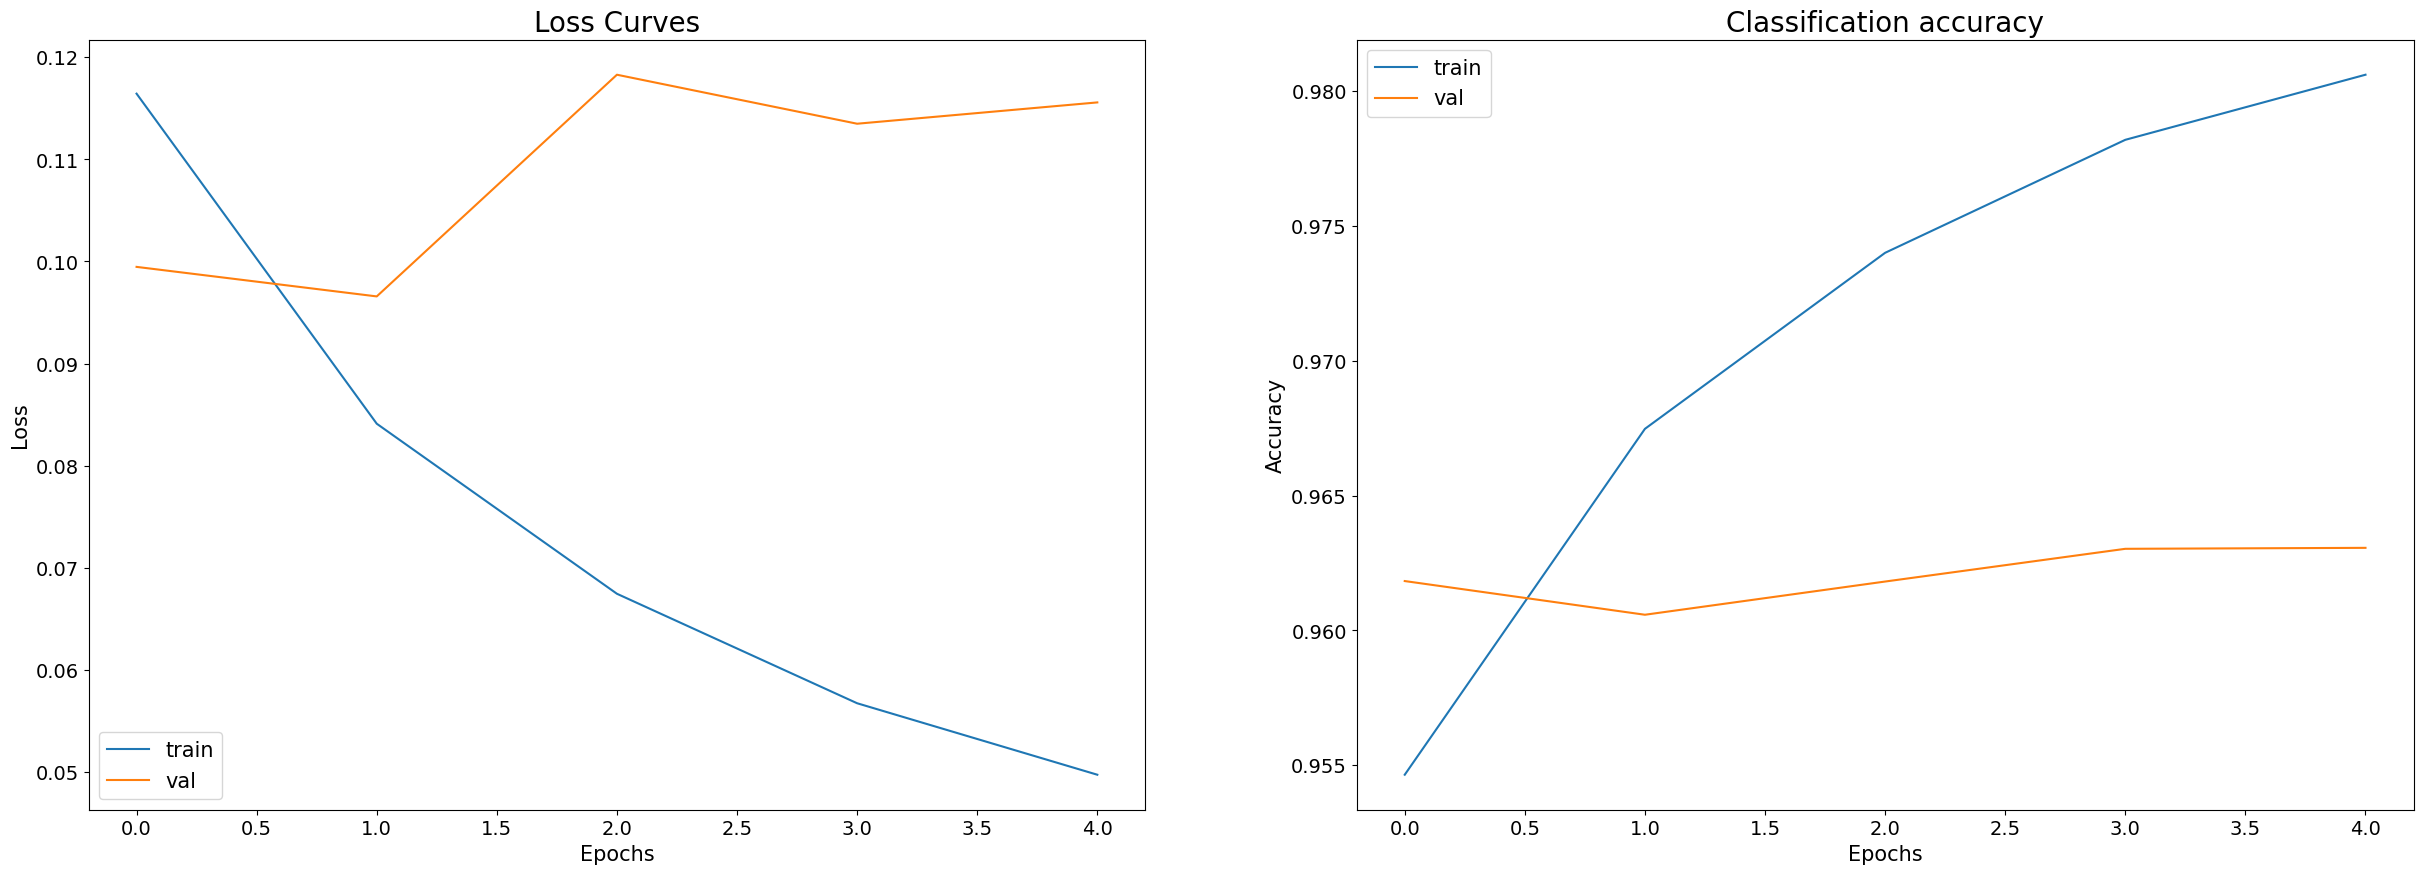

In [ ]:
print(summarize_diagnostics(history))

In [ ]:
# Make predictions on the test set
predictions = model.predict([test_input_ids, test_attention_mask])
predicted_labels = np.argmax(predictions.logits, axis=1)

# Evaluate the performance of the model
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

1188/1188 [==============================] - 90s 73ms/step
Accuracy: 0.9643


# Sentiment Analysis

In [ ]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df = pd.read_csv(data_path + 'all_reviews/bert_reviews.csv', parse_dates=['date'])

In [ ]:
# Drop rows with empty strings in the 'reviews' column
df = df.drop(df[df['reviews'] == ''].index)

# Drop rows with NaN values in the 'reviews' column
df = df.dropna(subset=['reviews'])

In [ ]:
df.head(5)

,listing_id,date,reviews
0,2265,2009-03-17,i stayed here during sxsw and had really pleas...
1,2265,2009-03-22,"great place, close enough to everything downto..."
2,2265,2011-03-16,we had great time in austin staying at paddy's...
3,2265,2012-03-15,we had great stay at zen east for south by sou...
4,2265,2012-03-19,i arrived late in the evening so did not meet ...


## Roberta

In [ ]:
model = TFRobertaForSequenceClassification.from_pretrained(data_path + "Roberta_model")
tokenizer = AutoTokenizer.from_pretrained(f"cardiffnlp/twitter-roberta-base-sentiment-latest")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/Shareddrives/Team_Airbnb/datasets/Roberta_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
# Test if model is working with an example
example = df['reviews'][22]
print(example)

the house was perfect. outdoor space and plenty of room. paddy made everything very easy. would definitely recommend.


In [ ]:
# Test Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='tf')
output = model(encoded_text)
scores = output[0][0].numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.00058617315, 'roberta_neu': 0.99941385, 'roberta_pos': 1.0469992e-11}


Roberta initialized on its own

In [ ]:
# Create empty lists to store the results of each analyzer
roberta_results = []

# Iterate over the 'reviews' column
for example in df['reviews']:
  encoded_text = tokenizer(example, return_tensors='tf')
  output = model(encoded_text)
  scores = output[0][0].numpy()
  scores = softmax(scores)
  roberta_scores_dict = {
      'roberta_neg': scores[0],
      'roberta_neu': scores[1],
      'roberta_pos': scores[2]}
  # Append results to respective lists
  roberta_results.append(roberta_scores_dict)

# Convert the results lists into new DataFrames
roberta_results_df = pd.DataFrame(roberta_results)

# Concatenate the original DataFrame with the results DataFrames
df_with_scores = pd.concat([df, roberta_results_df], axis=1)

# Print the updated DataFrame
df_with_scores

df_with_scores.to_csv(data_path + 'all_reviews/roberta_reviews.csv', index=False)

# VADER

In [ ]:
# Test run VADER
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Run example on VADER analyzer
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.531, 'pos': 0.469, 'compound': 0.9073}

In [ ]:
# Initialize VADER on data
# Create empty lists to store the results of each analyzer
sia_results = []

# Create an instance of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Iterate over the 'reviews' column
for example in df['reviews']:
    # Calculate sentiment scores using SentimentIntensityAnalyzer
    sentiment_scores = sia.polarity_scores(example)

    sia_scores_dict = {
        'sia_neg': sentiment_scores['neg'],
        'sia_neu': sentiment_scores['neu'],
        'sia_pos': sentiment_scores['pos'],
        'sia_compound': sentiment_scores['compound']}

    # Append results to respective lists
    sia_results.append(sia_scores_dict)

# Convert the results lists into new DataFrames
sia_results_df = pd.DataFrame(sia_results)

# Concatenate the original DataFrame with the results DataFrames
df_with_scores2 = pd.concat([df, sia_results_df], axis=1)

df_with_scores2

df_with_scores2.to_csv(data_path + 'all_reviews/vader_reviews.csv', index=False)

Both: roberta and vader

Requires sufficient RAM

In [ ]:
# # Create empty lists to store the results of each analyzer
# roberta_results = []
# sia_results = []

# # Create an instance of SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()

# # Iterate over the 'reviews' column
# for example in df['reviews']:
#     encoded_text = tokenizer(example, return_tensors='tf')
#     output = model(encoded_text)
#     scores = output[0][0].numpy()
#     scores = softmax(scores)
#     roberta_scores_dict = {
#         'roberta_neg': scores[0],
#         'roberta_neu': scores[1],
#         'roberta_pos': scores[2]
#     }

#     # Calculate sentiment scores using SentimentIntensityAnalyzer
#     sentiment_scores = sia.polarity_scores(example)

#     sia_scores_dict = {
#         'sia_neg': sentiment_scores['neg'],
#         'sia_neu': sentiment_scores['neu'],
#         'sia_pos': sentiment_scores['pos'],
#         'sia_compound': sentiment_scores['compound']
#     }

#     # Append results to respective lists
#     roberta_results.append(roberta_scores_dict)
#     sia_results.append(sia_scores_dict)

# # Convert the results lists into new DataFrames
# roberta_results_df = pd.DataFrame(roberta_results)
# sia_results_df = pd.DataFrame(sia_results)

# # Concatenate the original DataFrame with the results DataFrames
# df_with_scores = pd.concat([df, roberta_results_df, sia_results_df], axis=1)
# Print the updated DataFrame

# df_with_scores

# df_with_scores.to_csv(data_path + 'all_reviews/roberta_reviews.csv', index=False)